# Проект «ML для текстов»

Интернет-магазин «Викишоп» внедряет новый сервис, позволяющий пользователям редактировать и дополнять описания товаров. Такой подход, похожий на функционирование вики-сообществ, расширяет возможности клиентов и делает контент более актуальным. Однако с открытием редактирования возрастает риск появления токсичных комментариев, которые могут негативно повлиять на атмосферу сервиса. Для решения этой проблемы требуется инструмент, автоматически классифицирующий комментарии и отправляющий токсичные на модерацию.

Цель работы — создать модель машинного обучения, которая будет эффективно определять токсичные комментарии. Для выполнения этой задачи мы используем набор данных представленный в файле toxic_comments.csv. Столбец text содержит тексты комментариев, а столбец toxic — целевой признак, указывающий на их характер (0 — нетоксичный, 1 — токсичный).

Чтобы достичь поставленной цели и обеспечить высокое качество классификации, необходимо выполнить следующие шаги:

- Загрузка и подготовка данных: изучить структуру данных, выполнить предобработку текста, устранить пропуски и привести данные к виду, пригодному для обучения моделей.
- Обучение моделей: протестировать несколько алгоритмов классификации, выбрать лучшие гиперпараметры и провести оценку моделей.
- Оценка качества: выбрать оптимальную модель, достигшую значения метрики F1 не менее 0.75.


По итогам проекта будет разработан инструмент для автоматической классификации комментариев, который поможет улучшить взаимодействие пользователей с платформой и сократить объем работы модераторов.

## Подготовка

In [1]:
!pip install scikit-learn==1.1.3
!pip install spacy
!pip install tqdm

import time
import warnings
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import (RandomizedSearchCV, train_test_split)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from nltk.probability import FreqDist
from tqdm.notebook import tqdm

# Импорт NLTK
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

# Загрузка других необходимых ресурсов NLTK
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Импорт лемматизатора и токенизатора
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

# Отключение предупреждений
warnings.filterwarnings("ignore")

# Настройка tqdm для прогресс-баров
tqdm.pandas()

# Установка фиксированного значения для генератора случайных чисел
RANDOM_STATE = 42

# Импорт облака слов
!/opt/conda/bin/python -m pip install wordcloud==1.8.2.2  
!pip install Pillow==9.5.0
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Для начала загрузим наш исходный датасет

In [2]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
display(toxic_comments.info())
display(toxic_comments.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Датафрейм содержит почти 160 тыс. записей. Признак text — тексты твитов для обучения, а toxic — целевой признак для классификации.

Как видно, столбец Unnamed: 0 содержит значения, которые полностью совпадают с индексами строк. Поэтому его можно безопасно удалить.

In [4]:
toxic_comments = toxic_comments.drop('Unnamed: 0', axis=1)

Проверим данные на дубликаты:

In [5]:
print(toxic_comments.duplicated().sum())

0


Проверим уникальные значения в столбце toxic

In [6]:
print(toxic_comments['toxic'].unique())

[0 1]


Построим гистограмму для переменной toxic, чтобы увидеть, насколько сбалансированы наши классы. Это помогает понять, есть ли в данных дисбаланс, который может повлиять на качество модели

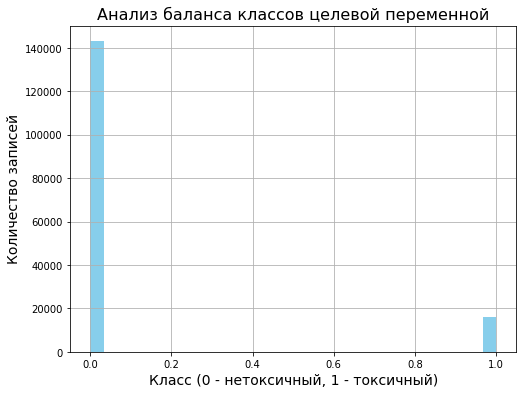

In [7]:
plt.figure(figsize=(8, 6))
toxic_comments['toxic'].hist(bins=30, color='skyblue')

# Добавляем заголовок и подписи осей
plt.title('Анализ баланса классов целевой переменной', fontsize=16)
plt.xlabel('Класс (0 - нетоксичный, 1 - токсичный)', fontsize=14)
plt.ylabel('Количество записей', fontsize=14)
plt.show()

Как видно по результатам выше, наш исходный датафрейм включает в себя около 160 тысяч строк, что является достаточно значительным объемом данных. Наши данные чистые, без дубликатов, а признак toxic содержит несбалансированные классы с существенным перевесом класса 0 чуть ли не в 7 раз, что нужно учитывать при дальнейшей работе.

В столбце text присутствуют ненужные символы, которые могут помешать дальнейшей обработке данных. Чтобы обеспечить более качественную работу с комментариями, следует удалить эти лишние символы.

In [8]:
# Функция для удаления лишних символов
def clean_text(text):
    text = re.sub(r'[\n\r\s]+', ' ', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.lower()
    return text

toxic_comments['text'] = toxic_comments['text'].apply(clean_text)

# Проверим несколько строк
print(toxic_comments.head())

                                                text  toxic
0  explanation why the edits made under my userna...      0
1  daww he matches this background colour im seem...      0
2  hey man im really not trying to edit war its j...      0
3  more i cant make any real suggestions on impro...      0
4  you sir are my hero any chance you remember wh...      0


Далее произведем подсчёт статистики встречаемости слов в тексте. Для этого сначала разобьем наш очищенный текст на слова, а потом построим график, для 20 наиболее встречающихся слов, и облако слов (применим класс FreqDist (frequency distributions))

In [9]:
all_words = toxic_comments['text'].fillna('').apply(word_tokenize).explode()

In [10]:
fdist = FreqDist(all_words)

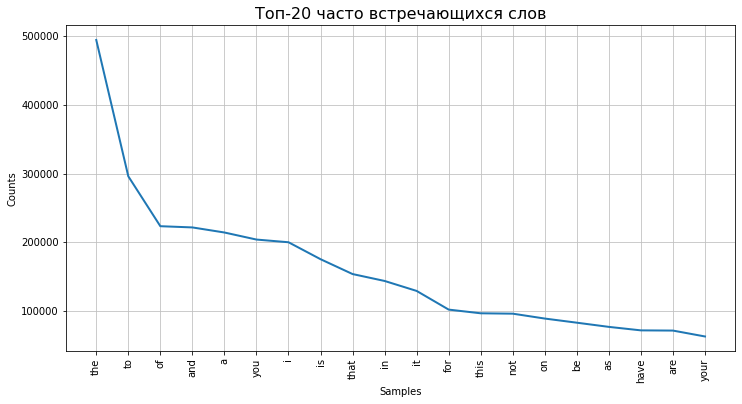

In [11]:
# Построение графика
plt.figure(figsize=(12, 6))
plt.title('Топ-20 часто встречающихся слов', fontsize=16)
fdist.plot(20,cumulative=False)
plt.show()

In [12]:
fdist.most_common(10)

[('the', 494380),
 ('to', 296086),
 ('of', 223491),
 ('and', 221711),
 ('a', 214330),
 ('you', 204064),
 ('i', 200148),
 ('is', 175502),
 ('that', 153890),
 ('in', 143840)]

Как видно из данного графика, большинство частовстречающихся слов в этом наборе данных в основном состоит группа из слов, не несущих глубокого смыслового содержания, таких как артикли, предлоги и местоимения. Это подтверждает, что для более глубокого анализа текста полезно исключать такие стоп-слова.

In [13]:
filtered_words = [word for word in all_words if word not in stopwords]

In [14]:
text = nltk.Text(filtered_words)

In [15]:
fdist_nostop = FreqDist(text)
fdist_nostop.most_common(10)

[('article', 55336),
 ('page', 45526),
 ('wikipedia', 35484),
 ('talk', 31470),
 ('please', 29566),
 ('would', 29154),
 ('one', 27992),
 ('like', 27636),
 ('dont', 26032),
 ('see', 21440)]

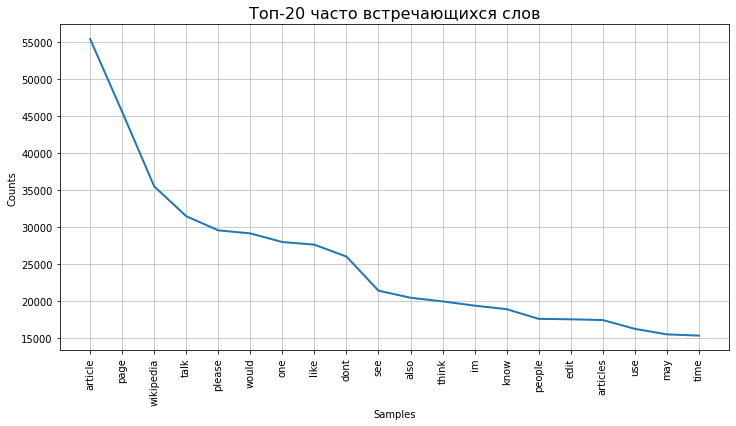

In [16]:
# Построение графика
plt.figure(figsize=(12, 6))
plt.title('Топ-20 часто встречающихся слов (без стопслов)', fontsize=16)
fdist_nostop.plot(20,cumulative=False)
plt.show()

Построим облако слов

In [17]:
%matplotlib inline
filtered_words_clean = [str(word) for word in fdist_nostop if isinstance(word, str)]

# Создание текста из слов
text_raw = ' '.join(filtered_words_clean)

In [18]:
wordcloud = WordCloud().generate(text_raw)

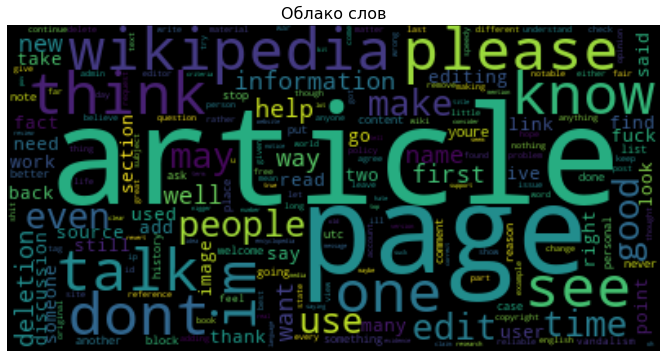

In [19]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Облако слов', fontsize=16)
plt.show()

Облако слов, представленное на графике, визуализирует наиболее часто встречающиеся слова в тексте. Мы видим, что в основном слова связаны с тематикой Википедии, обсуждениями и просьбами.  Оно помогает выделить основные темы, характер общения и часто употребляемые слова, что может быть полезно для дальнейшего анализа текстовых данных и построения моделей.

Далее сделам лемматизацию текста для того, чтобы привести текст к более стандартизированной форме, что сделает его более удобным для дальнейшего анализа или построения моделей машинного обучения. Используем WordNetLemmatizer, который позволяет не только привести слова к их базовой форме, но и делать это с учетом контекста, что значительно повышает точность обработки текста, особенно для задач анализа текста и машинного обучения, и обеспечит нас более качественными результатами. Используем POS-тегирование и лемматизацию с учётом части речи (POS) для улучшения качества обработки текста.

In [20]:
lemmatizer = WordNetLemmatizer()

In [21]:
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,  # Прилагательное
        'N': wordnet.NOUN,  # Существительное
        'V': wordnet.VERB,  # Глагол
        'R': wordnet.ADV,   # Наречие
    }
    return tag_dict.get(tag, wordnet.NOUN)

In [22]:
# Функция для лемматизации с учётом POS-тегов
def lemmatize_text_with_pos(text):
    # Токенизация текста (разделение на слова)
    words = word_tokenize(text)
    # Лемматизация каждого слова с учётом его POS-тега
    lemmatized_words = [
        lemmatizer.lemmatize(word, pos=get_wordnet_pos(word)) for word in words if word.lower() not in stopwords
    ]
    # Объединение слов обратно в строку
    return " ".join(lemmatized_words)

In [23]:
# Применяем лемматизацию с учётом POS-тегов
toxic_comments['lemmatized_text'] = toxic_comments['text'].progress_apply(lemmatize_text_with_pos)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [24]:
print(toxic_comments.head(3))

                                                text  toxic  \
0  explanation why the edits made under my userna...      0   
1  daww he matches this background colour im seem...      0   
2  hey man im really not trying to edit war its j...      0   

                                     lemmatized_text  
0  explanation edits make username hardcore metal...  
1  daww match background colour im seemingly stuc...  
2  hey man im really try edit war guy constantly ...  


Как мы видит, после комбинации POS-тегирования и лемматизации с учётом части речи мы получаем более точные лемматизированные формы слов, что значительно улучшает нашу обработку текста.

**Итак, в первой части работы** мы загрузили исходный датасет, провели его анализ и выянили, что он содержит почти 160 тыс. записей. Признак text включает тексты твитов для обучения, а toxic — целевой признак для классификации. Лишний столбец Unnamed: 0 был удален, так как он дублирует индекс строк. 

Проверили наши данные на дубликаты и  проверка показала их отсутствие, а в столбце toxic содержатся лишь уникальные значения 0 и 1. Также мы построили гистограмму для нашей целевой переменной, чтобы увидеть, насколько сбалансированы наши классы и выявили, что  в признаке toxic классы несбалансированы, с существенным перевесом класса 0.

В столбце text были выявлены ненужные символы, которые могли бы помешать дальнейшей обработке и обучению. Для улучшения качества анализа текста, эти символы были удалены.

Также мы произвели подсчёт статистики встречаемости слов в тексте и построили графики и облако слов. Самые встречающиеся слова это article', 'page', 'wikipedia' и большинство слов связаны с тематикой Википедии, обсуждениями и просьбами.

Далее был применен процесс лемматизации с использованием WordNetLemmatizer для приведения слов к их базовой форме, чтобы улучшить точность анализа и моделирования. И после также было проведено POS-тегирование для учета частей речи, что позволило повысить точность лемматизации и улучшить обработку текста.

После предобработки данных, включая удаление ненужных символов, лемматизацию с учётом частей речи и подготовку целевого признака, мы готовы к обучению модели. Данные теперь находятся в нужном формате для дальнейшего анализа и построения классификатора для предсказания токсичности твитов.

В результате проведенной предобработки данных мы подготовили их для последующего анализа и построения модели для предсказания токсичности твитов. Выполненные шаги гарантируют целостность и качество данных, что создает надежную основу для эффективного анализа и точных предсказаний в дальнейшем.

## Обучение

Для начала разделим выборки на тренировучную и тестовую. Стоблец toxic содержит целевой признак.

In [25]:
data = toxic_comments.copy()
X = data.drop('toxic', axis=1)
y = data['toxic']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

**1. Модель LogisticRegression**

In [27]:
X_train_lr = X_train.copy()
y_train_lr = y_train.copy()
X_test_lr = X_test.copy()
y_test_lr = y_test.copy()

In [28]:
X_train_lr = X_train_lr['lemmatized_text']
X_test_lr = X_test_lr['lemmatized_text']

Преобразование текстовых данных в числовые представления произведем с помощью векторизации на основе TF-IDF в pipeline. Это необходимо для подготовки текстовых данных к дальнейшему обучению модели машинного обучения.

In [29]:
pipe_lr = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords)),
    ('tfidf', TfidfTransformer()),
    ('model', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, solver='liblinear'))
])

In [30]:
# Гиперпараметры для LogisticRegression
param_grid_lr = {
    'model__penalty' : ['l1', 'l2'],
    'model__C': list(range(1,15,3))
}

random_search_lr = RandomizedSearchCV(
    pipe_lr, 
    param_distributions=param_grid_lr, 
    cv=5,
    scoring='f1', 
    random_state=RANDOM_STATE,
    n_iter=8,
    n_jobs=-1
)

random_search_lr.fit(X_train_lr, y_train_lr)

lr_params = random_search_lr.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", lr_params)
print("Метрика f1, полученная с помощью кросс валидации:", (random_search_lr.best_score_))


Лучшие параметры: {'model__penalty': 'l1', 'model__C': 4}
Метрика f1, полученная с помощью кросс валидации: 0.7581902676466654


In [31]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
lr_model = random_search_lr.best_estimator_

lr_model.fit(X_train_lr, y_train_lr)

# Время обучения
end = time.time()
time_lr_fit =end-start
print(f"Время обучения модели LogisticRegression на тренировочной выборке: {time_lr_fit:.2f} секунд")

Время обучения модели LogisticRegression на тренировочной выборке: 9.54 секунд
CPU times: user 9.22 s, sys: 58.3 ms, total: 9.28 s
Wall time: 9.54 s


In [32]:
%%time
# Время предсказания модели LogisticRegression
start_time = time.time()
y_pred_lr = lr_model.predict(X_test_lr)
end_time = time.time()
prediction_time_lr = end_time - start_time
print(f"Время предсказания модели LogisticRegression: {prediction_time_lr:.2f} секунд")

Время предсказания модели LogisticRegression: 1.56 секунд
CPU times: user 1.52 s, sys: 30.5 ms, total: 1.55 s
Wall time: 1.56 s


Мы провели обучение модели LogisticRegression с использованием оптимальных гиперпараметров: penalty установлен в 'l1', а C составляет 4. Качество модели на кросс-валидации: 0.76 (метрика f1). Время обучения модели на тренировочной выборке составило несколько секунд, что соответствует обычным временным затратам для данной модели. Время предсказания также оказалось минимальным, что подтверждает быструю работу модели. Эти результаты потом используем для сравнения с другими моделями.

Теперь также посмотрим, какие слова являются наиболее важными для классификации модели логистической регрессии. 

In [33]:
# список слов
feature_names = random_search_lr.best_estimator_.named_steps['vect'].get_feature_names_out()
# коэффициенты важности (для логистической регрессии)
coefficients = random_search_lr.best_estimator_.named_steps['model'].coef_.tolist()[0]

In [34]:
# Создаем DataFrame с коэффициентами и словами
importance_df = pd.DataFrame({
    'word': feature_names,
    'importance': coefficients
})

In [35]:
# Сортируем по важности
importance_df = importance_df.sort_values(by='importance', ascending=False)
top_words = importance_df.head(20)
display(top_words.head(5))

,word,importance
52250,fuck,69.591459
15830,bitch,38.863942
47208,faggot,35.021960
9762,asshole,34.937594
129657,shit,34.479145


Мы нашли слова оказывающие большое влияние на предсказания модели, то есть модель считает эти слова важными при принятии решения о классификации текста. Судя по выводимым результатам, в данном наборе данных для модели было выделено слово "fuck", как наиболее важное для классификации, с высоким коэффициентом важности. Теперь, построим график для большей наглядности.

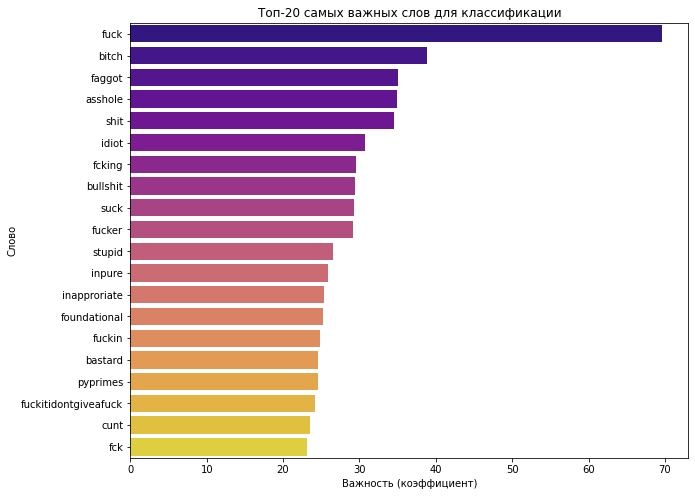

In [36]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='word', data=top_words, palette='plasma')
plt.title('Топ-20 самых важных слов для классификации')
plt.xlabel('Важность (коэффициент)')
plt.ylabel('Слово')
plt.show()

**2. Модель DecisionTreeClassifier**

In [37]:
X_train_dt = X_train.copy()
y_train_dt = y_train.copy()
X_test_dt = X_test.copy()
y_test_dt = y_test.copy()

In [38]:
X_train_dt = X_train_dt['lemmatized_text']
X_test_dt = X_test_dt['lemmatized_text']

In [39]:
pipe_dt = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords)),
    ('tfidf', TfidfTransformer()),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

In [40]:
# Гиперпараметры для DecisionTreeClassifier
param_grid_dt = {
    'model__max_depth': [10, 15, 20, 30],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [2, 5],
}

random_search_dt = RandomizedSearchCV(
    pipe_dt, 
    param_distributions=param_grid_dt, 
    scoring='f1',  
    random_state=RANDOM_STATE, 
    n_iter=5, 
    cv=3,  
    n_jobs=-1 
)

random_search_dt.fit(X_train_dt, y_train_dt)

dt_params = random_search_dt.best_params_

print()
print("Лучшие параметры:", dt_params)
print("Метрика f1, полученная с помощью кросс валидации:", random_search_dt.best_score_)


Лучшие параметры: {'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 30}
Метрика f1, полученная с помощью кросс валидации: 0.6136535121941346


In [41]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
dt_model = random_search_dt.best_estimator_

dt_model.fit(X_train_dt, y_train_dt)

# Время обучения
end = time.time()
time_dt_fit =end-start
print(f"Время обучения модели DecisionTreeClassifier на тренировочной выборке: {time_dt_fit:.2f} секунд")

Время обучения модели DecisionTreeClassifier на тренировочной выборке: 35.89 секунд
CPU times: user 35.7 s, sys: 177 ms, total: 35.9 s
Wall time: 35.9 s


In [42]:
%%time
# Время предсказания модели DecisionTreeClassifier
start_time = time.time()
y_pred_dt = dt_model.predict(X_test_dt)
end_time = time.time()
prediction_time_dt = end_time - start_time
print(f"Время предсказания модели DecisionTreeClassifier: {prediction_time_dt:.2f} секунд")

Время предсказания модели DecisionTreeClassifier: 1.37 секунд
CPU times: user 1.36 s, sys: 2.42 ms, total: 1.36 s
Wall time: 1.37 s


Мы провели обучение модели DecisionTreeClassifier с использованием оптимальных гиперпараметров: min_samples_split установлен на 10, min_samples_leaf равен 2, а max_depth составляет 30. Качество модели на кросс-валидации: 0.61 (метрика f1). Время обучения модели на тренировочной выборке составило несколько секунд, но немного больше, чем у предыдущей модели, и время предсказания оказалось быстрым, что подтверждает быстродействие модели. Эти результаты будем использовать для дальнейшего сравнения с другими моделями.

**3. Модель RandomForestClassifier**

In [43]:
X_train_rf = X_train.copy()
y_train_rf = y_train.copy()
X_test_rf = X_test.copy()
y_test_rf = y_test.copy()

In [44]:
X_train_rf = X_train_rf['lemmatized_text']
X_test_rf = X_test_rf['lemmatized_text']

In [45]:
pipe_rf = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords)),
    ('tfidf', TfidfTransformer()),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

In [46]:
# Гиперпараметры для RandomForestClassifier
param_grid_rf = {
    'model__max_depth': [10, 15, 20], 
    'model__n_estimators': list(range(50, 300, 50)) 
                                }

random_search_rf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=param_grid_rf, 
    scoring='f1',
    random_state=RANDOM_STATE,
    n_iter=5,  
    cv=3, 
    n_jobs=-1  
)

random_search_rf.fit(X_train_rf, y_train_rf)

rf_params = random_search_rf.best_params_

# Вывод лучших параметров и значения метрики
print()
print("Лучшие параметры:", rf_params)
print("Метрика f1, полученная с помощью кросс валидации:", random_search_rf.best_score_)


Лучшие параметры: {'model__n_estimators': 200, 'model__max_depth': 20}
Метрика f1, полученная с помощью кросс валидации: 0.40064724647133515


In [47]:
%%time
# Засекаем время обучения модели на всей тренировочной выборке с лучшими параметрами
start = time.time()

# Создаем переменную с моделью с лучшими параметрами
rf_model = random_search_rf.best_estimator_

rf_model.fit(X_train_rf, y_train_rf)

# Время обучения
end = time.time()
time_rf_fit =end-start
print(f"Время обучения модели RandomForestClassifier на тренировочной выборке: {time_rf_fit:.2f} секунд")

Время обучения модели RandomForestClassifier на тренировочной выборке: 34.29 секунд
CPU times: user 33.9 s, sys: 99.6 ms, total: 34 s
Wall time: 34.3 s


In [48]:
%%time
# Время предсказания модели RandomForestClassifier
start_time = time.time()
y_pred_rf = rf_model.predict(X_test_rf)
end_time = time.time()
prediction_time_rf = end_time - start_time
print(f"Время предсказания модели RandomForestClassifier: {prediction_time_rf:.2f} секунд")

Время предсказания модели RandomForestClassifier: 3.05 секунд
CPU times: user 3.04 s, sys: 7.61 ms, total: 3.05 s
Wall time: 3.05 s


Мы провели обучение модели RandomForestClassifier с использованием оптимальных гиперпараметров: количество деревьев в лесу (n_estimators) установлено на уровне 200, а максимальная глубина деревьев (max_depth) составляет 20. Качество модели на кросс-валидации: 0.40 (метрика f1). Время обучения модели на тренировочной выборке составило несколько секунд, а время предсказания оказалось вполне приемлемым для данной модели. Эти результаты затем будут использоваться для сравнения с другими моделями.

**Итак, во второй части работы** мы обучили несколько моделей машинного обучения, проведя подбор и настройку гиперпараметров с использованием кросс-валидации для оценки качества моделей. Были рассмотрены модели LogisticRegression, DecisionTreeClassifier и RandomForestClassifier. 

В пайплайн была добавлена обработка с использованием TF-IDF, что позволило избежать утечки данных и обеспечило корректную векторизацию текстов без учета информации из тестовой выборки. Мы также проанализировали важность слов для классификации с точки зрения модели логистической регрессии. Это позволило нам выявить, какие слова оказывают наибольшее влияние на предсказания модели. Среди наиболее значимых слов было выделено слово "fuck", которое имеет высокий коэффициент важности, что говорит о его сильном влиянии на классификацию текста. И потом построили график важности слов.

Далее мы измерили время обучения на тренировочной выборке и время предсказания на тестовой выборке. Результаты будем использовать дальше при сравнении моделей и выбора наиболее подходящей их них.

## Оценка качества моделей

Составим таблицу, отражающую все найденные результаты 

In [49]:
lr_f1_train = random_search_lr.best_score_
dt_f1_train = random_search_dt.best_score_
rf_f1_train = random_search_rf.best_score_

In [50]:
# Создание DataFrame с нашими результатами
results = pd.DataFrame({
    'Модель': ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier'],
    'F1': [lr_f1_train, dt_f1_train, rf_f1_train],
    'Время предсказания (сек)': [prediction_time_lr, prediction_time_dt, prediction_time_rf],
    'Время обучения (сек)': [time_lr_fit, time_dt_fit, time_rf_fit]  
})

# Вывод результатов
results

,Модель,F1,Время предсказания (сек),Время обучения (сек)
0,LogisticRegression,0.758190,1.556964,9.538763
1,DecisionTreeClassifier,0.613654,1.371718,35.894492
2,RandomForestClassifier,0.400647,3.053534,34.286217


LogisticRegression с гиперпараметрами penalty='l1' и C=4 показала лучший результат по метрике F1 — 0.76. Время обучения составило несколько секунд, а время предсказания было минимальным, что делает эту модель самой быстрой в тестировании. Этот результат показывает высокое качество модели при относительно малых затратах времени на обучение и предсказание.

DecisionTreeClassifier с гиперпараметрами min_samples_split=10, min_samples_leaf=2 и max_depth=30 показала метрику F1 0.61. Хотя время обучения немного больше, чем у LogisticRegression, время предсказания оставалось быстрым. Однако, по метрике F1 модель уступает LogisticRegression.

RandomForestClassifier с гиперпараметрами n_estimators=200 и max_depth=20 показала наименьшую метрику F1 — 0.40, что делает её наименее эффективной по сравнению с другими моделями. Время обучения и предсказания составило примерно столько же сколько и у DecisionTreeClassifier, а по качеству модели она значительно уступает.

На основании метрики F1, которая для LogisticRegression составила примерно 0.76, эта модель показывает лучший результат среди рассмотренных. Поэтому LogisticRegression является наилучшей моделью для текущей задачи, удовлетворяя требованию F1 не ниже 0.75.

Найдем значение F1 на тестовой выборке для модели LogisticRegression:

In [51]:
# Оценка качества модели LogisticRegression на тестовой выборке
f1_test_lr = f1_score(y_test_lr, y_pred_lr)
print("F1 на тестовой выборке для модели LogisticRegression: %.2f" % f1_test_lr)

F1 на тестовой выборке для модели LogisticRegression: 0.76


Значение F1 на тестовой выборке для модели LogisticRegression составило 0.76. Это хороший результат, который указывает на сбалансированное сочетание точности и полноты предсказаний модели.

**Итак, в 3 шаге нашей работы** мы провели оценку качества моделей, чтобы выбрать наилучший вариант для нашей задачи. Были протестированы три модели: LogisticRegression, DecisionTreeClassifier, и RandomForestClassifier. Мы рассчитали ключевые метрики качества (F1) и сравнили их по времени обучения и времени предсказания.

Мы составили таблицу результатов, где представлены метрики F1, а также время, затраченное на обучение и предсказание для каждой модели. Это позволяет визуально и количественно сравнить производительность алгоритмов.

LogisticRegression показала лучший результат по метрике F1 (0.76) и продемонстрировала минимальное время обучения и предсказания. Она удовлетворяет требованию F1 ≥ 0.75.
DecisionTreeClassifier с F1 = 0.61 уступает LogisticRegression, хотя остаётся приемлемой по времени предсказания.
RandomForestClassifier продемонстрировала наихудшую метрику F1 (0.40) и большое время выполнения, что делает её наименее подходящей для задачи.

Поэтому наилучшим вариантом для задачи выбрана LogisticRegression, так как она сочетает высокую метрику F1 с минимальными затратами времени. Модель успешно протестирована на тестовой выборке, где её F1 составила 0.76, что подтверждает её качество.

## Выводы

В ходе работы была решена задача предсказания токсичности твитов. Мы прошли три основных этапа: предобработка данных, обучение моделей и оценка их качества.

Была произведена предобработка данных: Для начала мы провели анализ исходного датасета, удалили ненужные столбцы, проверили данные на дубликаты и убедились в уникальности значений целевого признака. Построили гистограмму для нашей целевой переменной toxic, где заметили, что наши классы несбалансированы, с существенным перевесом класса 0.
Произвели подсчёт статистики встречаемости слов в тексте и построили графики и облако слов. Из столбца с текстом твитов удалили лишние символы, которые могли помешать дальнейшему анализу. Выполнили лемматизацию текста с учётом POS-тегов, что позволило улучшить точность обработки текста и создать качественное представление данных для обучения моделей.

Потом мы приступили к обучению моделей: Сначала преобразовали текстовых данных в числовые использовав TF-IDF векторизацию.Потом провели настройку гиперпараметров моделей LogisticRegression, DecisionTreeClassifier и RandomForestClassifier с использованием кросс-валидации. Измерили время обучения и предсказания для каждой модели, чтобы учитывать их эффективность по скорости работы. Ктоме того, мы нашли слова оказывающие большое влияние на предсказания модели LogisticRegression и построили график.

И далее произвели оценку качества моделей: Мы построили таблицу результатов, сравнив модели по метрике F1, времени обучения и предсказания. LogisticRegression продемонстрировала лучший результат: F1 = 0.76 при минимальном времени обучения и предсказания. Она удовлетворяет поставленному требованию F1 ≥ 0.75. DecisionTreeClassifier показала F1 = 0.61, но уступила LogisticRegression как по точности, так и по скорости работы. RandomForestClassifier оказалась наименее эффективной с F1 = 0.40 и большими затратами времени.

Наилучшей моделью для задачи была выбрана LogisticRegression, так как она продемонстрировала сбалансированное сочетание высокой точности, минимального времени обучения и предсказания. Эта модель успешно прошла тестирование, подтвердив свою эффективность для предсказания токсичности твитов.

Проделанная работа позволила создать качественную модель для анализа текстов. Она может быть использована для фильтрации токсичного контента в социальных сетях, что может существенно улучшить пользовательский опыт и снизить уровень негативного воздействия на платформе.